# 数据准备
已经下载好需要使用的音频数据，准备好需要使用的环境

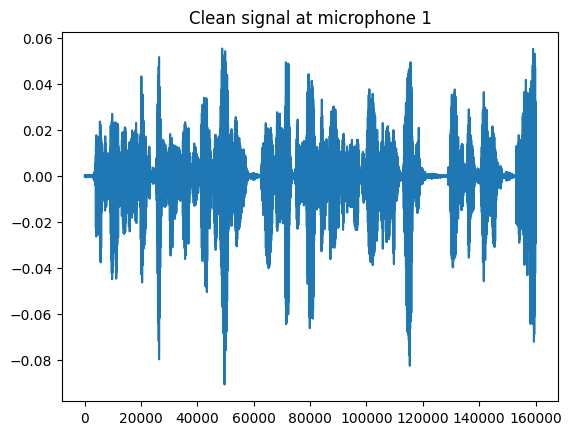

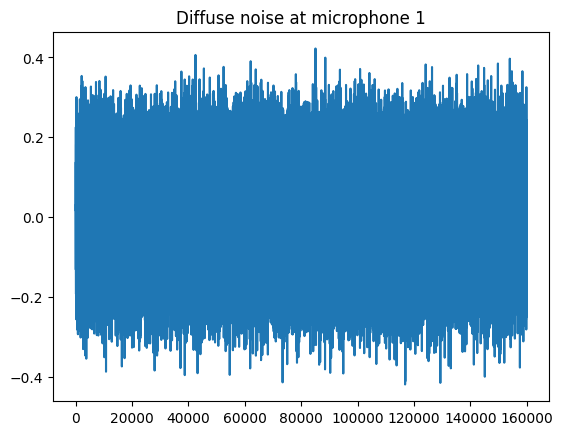

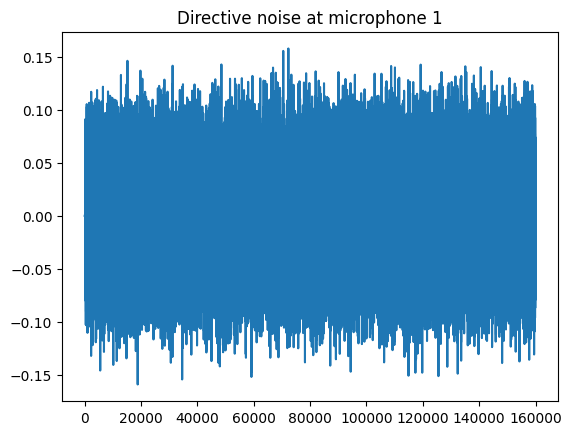

In [1]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio

xs_speech = read_audio('speech_-0.82918_0.55279_-0.082918.flac') # [time, channels]
xs_speech = xs_speech.unsqueeze(0) # [batch, time, channels]
xs_noise_diff = read_audio('noise_diffuse.flac') # [time, channels]
xs_noise_diff = xs_noise_diff.unsqueeze(0) # [batch, time, channels]
xs_noise_loc = read_audio('noise_0.70225_-0.70225_0.11704.flac') # [time, channels]
xs_noise_loc =  xs_noise_loc.unsqueeze(0) # [batch, time, channels]
fs = 16000 # sampling rate

plt.figure(1)
plt.title('Clean signal at microphone 1')
plt.plot(xs_speech.squeeze()[:,0])
plt.figure(2)
plt.title('Diffuse noise at microphone 1')
plt.plot(xs_noise_diff.squeeze()[:,0])
plt.figure(3)
plt.title('Directive noise at microphone 1')
plt.plot(xs_noise_loc.squeeze(0)[:,0])
plt.show()

回响的讲话：

In [2]:
from IPython.display import Audio
Audio(xs_speech.squeeze()[:,0],rate=fs)

我们现在将混响语音与噪声混合以创建噪声多通道混合物：

In [3]:
ss = xs_speech
nn_diff = 0.05 * xs_noise_diff
nn_loc = 0.05 * xs_noise_loc
xs_diffused_noise = ss + nn_diff
xs_localized_noise = ss + nn_loc

我们可以看看嘈杂的混合物：

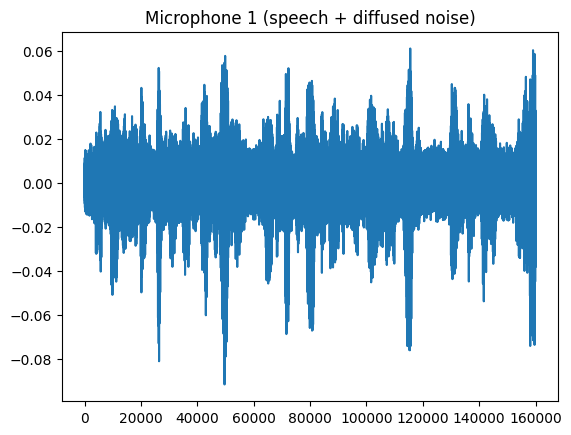

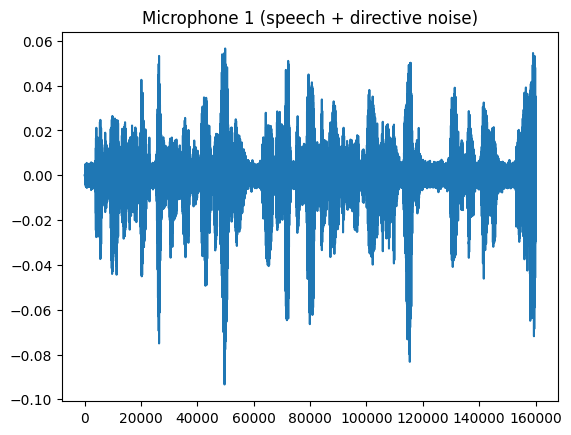

In [4]:
plt.figure(1)
plt.title('Microphone 1 (speech + diffused noise)')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(2)
plt.title('Microphone 1 (speech + directive noise)')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.show()

我们可以听到嘈杂的混合物：

In [6]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

In [7]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

# 数据处理
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 SRP-PHAT 模块将返回到达方向。我们需要提供麦克风阵列的几何形状，在本例中是一个圆形阵列，有四个均匀分布的麦克风，直径为 0.1m。系统估计每个 STFT 帧的 DOA。在此示例中，我们使用来自方向  x=−0.82918  、  y=0.55279  和  z=−0.082918  的声源。从结果中我们看到，方向是相当准确的（由于球体离散化，略有差异）。另请注意，由于所有麦克风均位于  xy  平面上，系统无法区分正  z  轴和负  z  轴。

In [8]:
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import SrpPhat

import torch

mics = torch.zeros((4,3), dtype=torch.float)
mics[0,:] = torch.FloatTensor([-0.05, -0.05, +0.00])
mics[1,:] = torch.FloatTensor([-0.05, +0.05, +0.00])
mics[2,:] = torch.FloatTensor([+0.05, +0.05, +0.00])
mics[3,:] = torch.FloatTensor([+0.05, +0.05, +0.00])

stft = STFT(sample_rate=fs)
cov = Covariance()
srpphat = SrpPhat(mics=mics)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
doas = srpphat(XXs)

print(doas)

tensor([[[-0.8284,  0.5570,  0.0588],
         [-0.8284,  0.5570,  0.0588],
         [-0.8284,  0.5570,  0.0588],
         ...,
         [-0.8284,  0.5570,  0.0588],
         [-0.8284,  0.5570,  0.0588],
         [-0.8284,  0.5570,  0.0588]]])


## Multiple Signal Classification
## 多信号分类
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 MUSIC 模块将返回到达方向。我们需要提供麦克风阵列的几何形状，在本例中是一个圆形阵列，有四个均匀分布的麦克风，直径为 0.1m。系统估计每个 STFT 帧的 DOA。在此示例中，我们使用来自方向  x=−0.82918  、  y=0.55279  和  z=−0.082918  的声源。从结果中我们看到，方向是相当准确的（由于球体离散化，略有差异）。另请注意，由于所有麦克风均位于  xy  平面上，系统无法区分正  z  轴和负  z  轴。

In [9]:
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Music

import torch

mics = torch.zeros((4,3), dtype=torch.float)
mics[0,:] = torch.FloatTensor([-0.05, -0.05, +0.00])
mics[1,:] = torch.FloatTensor([-0.05, +0.05, +0.00])
mics[2,:] = torch.FloatTensor([+0.05, +0.05, +0.00])
mics[3,:] = torch.FloatTensor([+0.05, +0.05, +0.00])

stft = STFT(sample_rate=fs)
cov = Covariance()
music = Music(mics=mics)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
doas = music(XXs)

print(doas)

tensor([[[-0.8271,  0.5576, -0.0702],
         [-0.8271,  0.5576, -0.0702],
         [-0.8271,  0.5576, -0.0702],
         ...,
         [-0.8271,  0.5576, -0.0702],
         [-0.8271,  0.5576, -0.0702],
         [-0.8271,  0.5576, -0.0702]]])


## Delay-and-Sum Beamforming
## 延迟和总和波束形成
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 GCC-PHAT模块将估计每个麦克风之间的到达时间差（TDOA），并使用该TDOA进行延迟和求和。

### 语音因弥漫性噪音而损坏

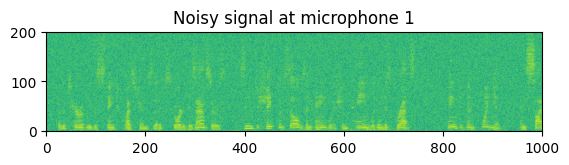

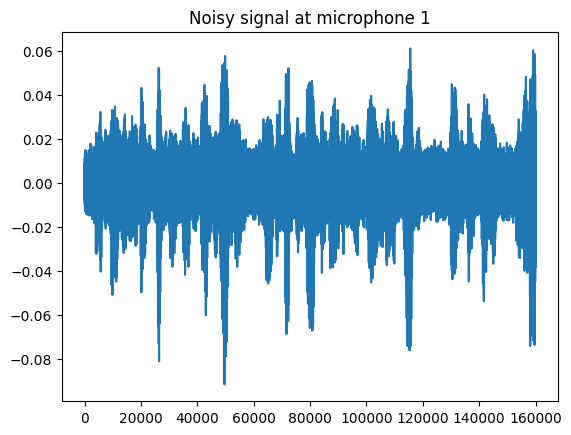

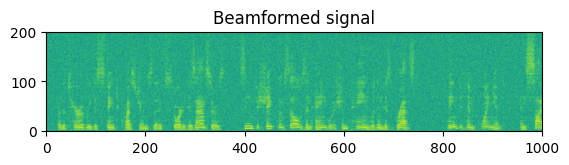

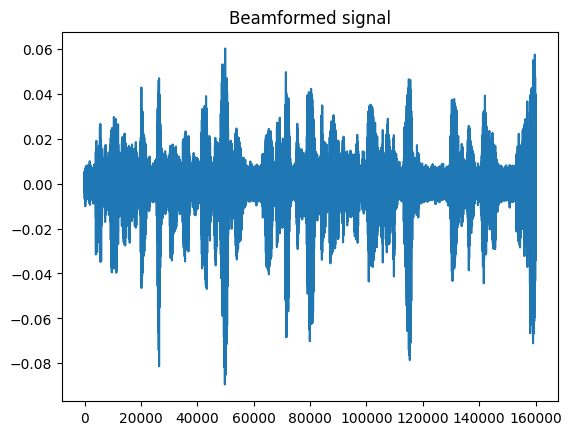

In [10]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import DelaySum

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
delaysum = DelaySum()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
tdoas = gccphat(XXs)
Ys_ds = delaysum(Xs, tdoas)
ys_ds = istft(Ys_ds)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_ds[0,:,:,0,0]**2 + Ys_ds[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_ds.squeeze())
plt.show()

我们还可以收听波束形成的信号并与噪声信号进行比较。

In [11]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

In [12]:
from IPython.display import Audio
Audio(ys_ds.squeeze(),rate=fs)

### 语音因指令性噪音而损坏
当我们有定向噪声时，这会更加棘手，因为 GCC-PHAT 可以从噪声源捕获 TDOA。现在我们简单地假设我们知道 TDOA，但可以应用理想的二进制掩码来区分语音 TDOA 和噪声 TDOA。

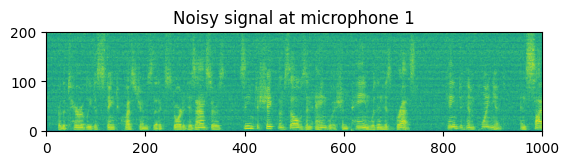

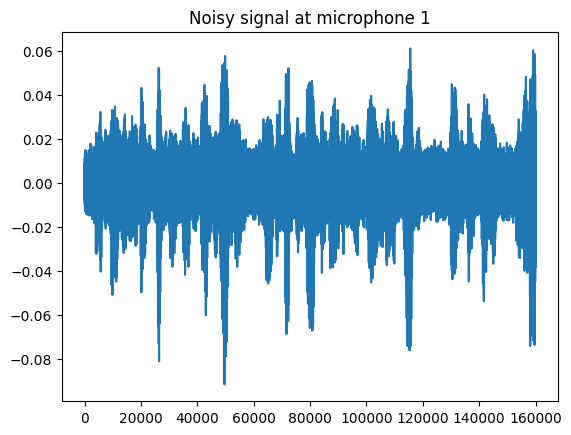

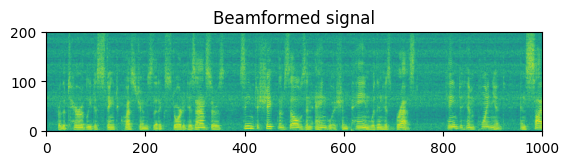

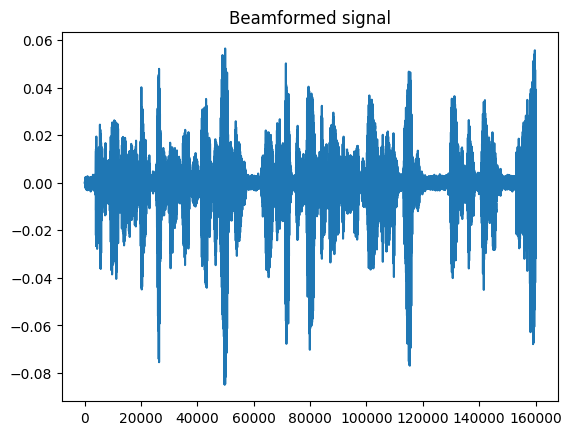

In [13]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import DelaySum

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
delaysum = DelaySum()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
tdoas = gccphat(XXs)

Xs = stft(xs_localized_noise)
XXs = cov(Xs)
Ys_ds = delaysum(Xs, tdoas)
ys_ds = istft(Ys_ds)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_ds[0,:,:,0,0]**2 + Ys_ds[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_ds.squeeze())
plt.show()

In [14]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [15]:
from IPython.display import Audio
Audio(ys_ds.squeeze(),rate=fs)

## Minimum Variance Distortionless Response
## 最小方差无失真响应
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 GCC-PHAT 模块将估计每个麦克风之间的到达时间差 (TDOA)，并使用此 TDOA 执行 MVDR 波束成形。

### Speech corrupted with diffuse noise
### 语音因弥漫性噪音而损坏

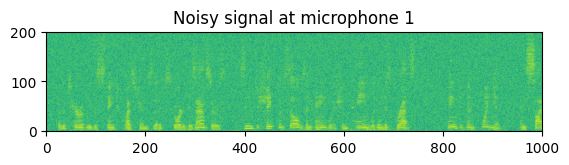

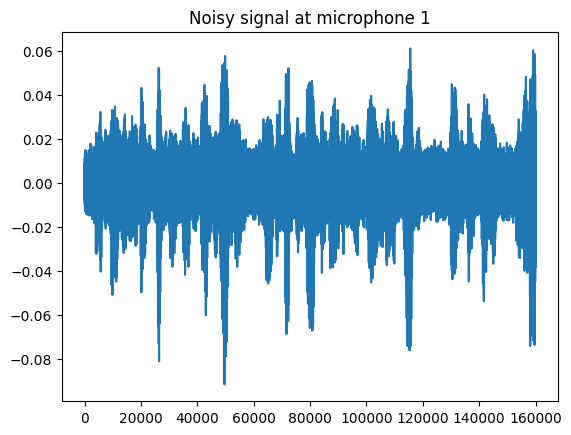

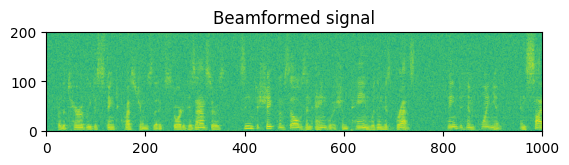

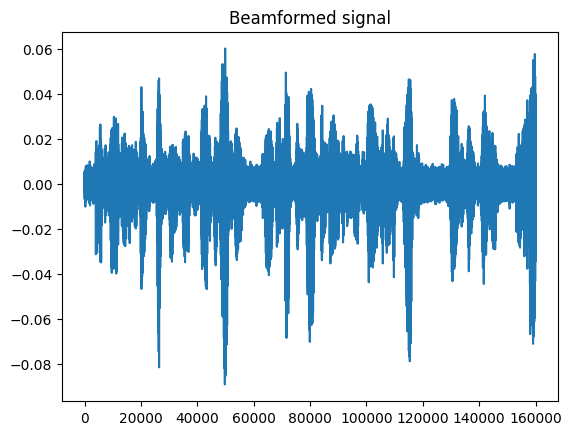

In [16]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import Mvdr

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
mvdr = Mvdr()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Nn = stft(nn_diff)
NNs = cov(Nn)
XXs = cov(Xs)
tdoas = gccphat(XXs)
Ys_mvdr = mvdr(Xs, NNs, tdoas)
ys_mvdr = istft(Ys_mvdr)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_mvdr[0,:,:,0,0]**2 + Ys_mvdr[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_mvdr.squeeze())
plt.show()

In [17]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

In [18]:
from IPython.display import Audio
Audio(ys_mvdr.squeeze(),rate=fs)

### Speech corrupted with directive noise
### 语音因指令性噪音而损坏
再次，当我们有定向噪声时，这会更加棘手，因为 GCC-PHAT 可以从噪声源捕获 TDOA。现在我们简单地假设我们知道 TDOA，但可以应用理想的二进制掩码来区分语音 TDOA 和噪声 TDOA。

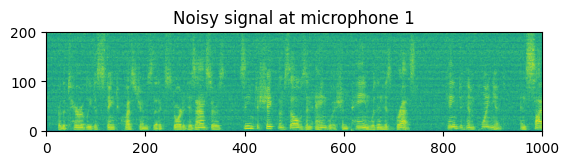

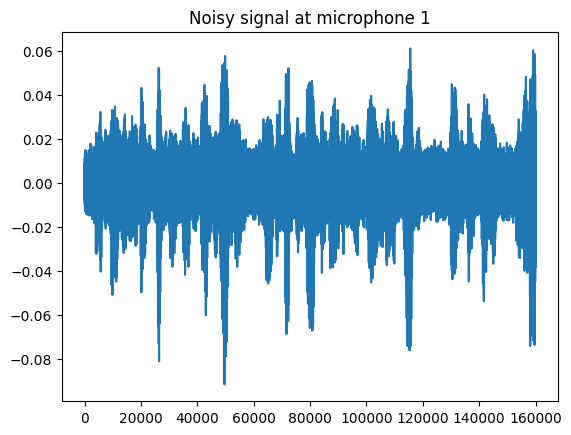

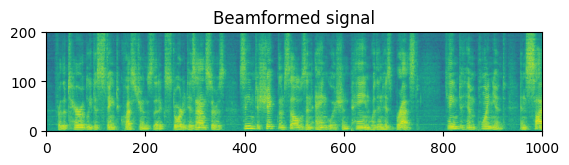

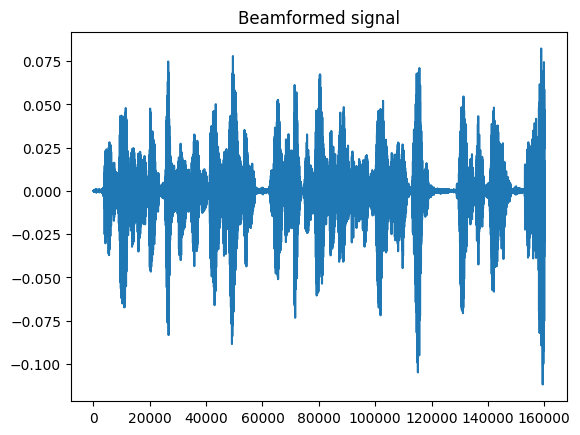

In [19]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import Mvdr

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
mvdr = Mvdr()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Nn = stft(nn_loc)
XXs = cov(Xs)
NNs = cov(Nn)
tdoas = gccphat(XXs)

Xs = stft(xs_localized_noise)
Ys_mvdr = mvdr(Xs, NNs, tdoas)
ys_mvdr = istft(Ys_mvdr)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_mvdr[0,:,:,0,0]**2 + Ys_mvdr[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_mvdr.squeeze())
plt.show()

In [20]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [21]:
from IPython.display import Audio
Audio(ys_mvdr.squeeze(),rate=fs)

## Generalized Eigenvalue Beamforming
## 广义特征值波束形成
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。我们假设我们可以分别计算语音和噪声的协方差矩阵，并将其用于波束成形。可以使用理想的二进制掩码来估计协方差矩阵。

### 语音因弥漫性噪音而损坏

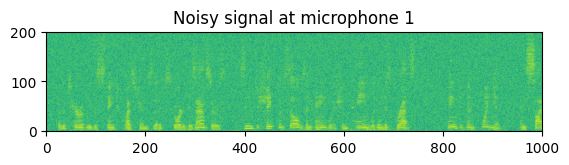

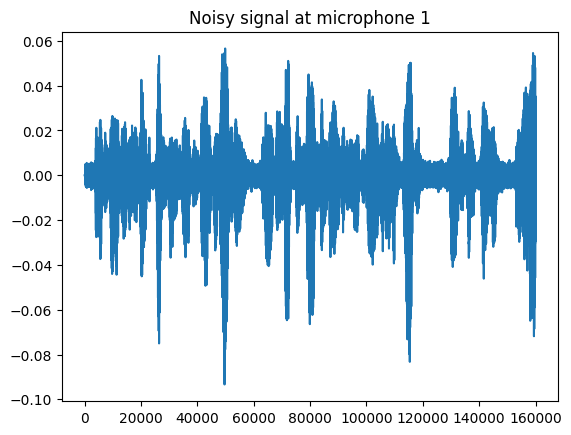

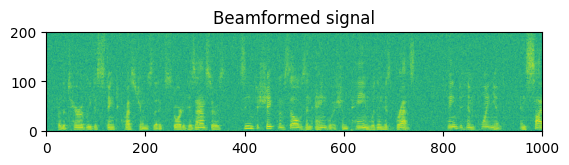

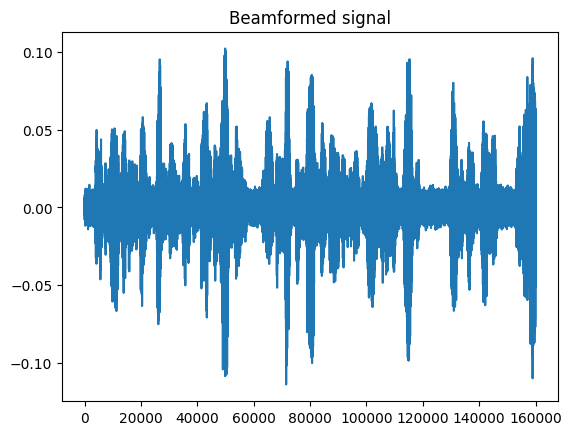

In [22]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Gev

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
gev = Gev()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Ss = stft(ss)
Nn = stft(nn_diff)
SSs = cov(Ss)
NNs = cov(Nn)
Ys_gev = gev(Xs, SSs, NNs)
ys_gev = istft(Ys_gev)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_gev[0,:,:,0,0]**2 + Ys_gev[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_gev.squeeze())
plt.show()

In [23]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [24]:
from IPython.display import Audio
Audio(ys_gev.squeeze(),rate=fs)

### 语音因指令性噪音而损坏

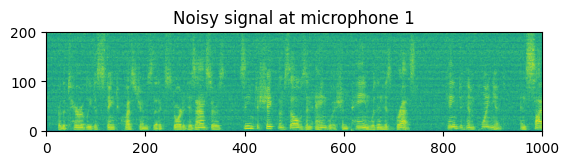

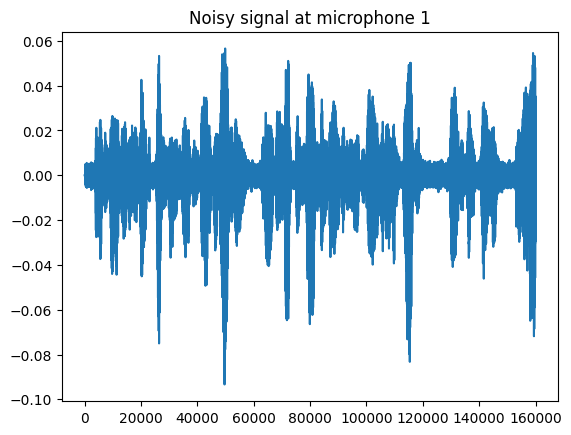

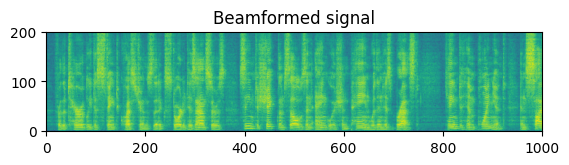

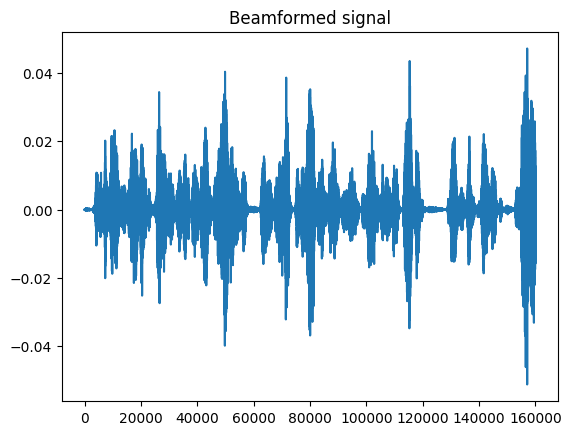

In [25]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Gev

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
gev = Gev()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_localized_noise)
Ss = stft(ss)
Nn = stft(nn_loc)
SSs = cov(Ss)
NNs = cov(Nn)
Ys_gev = gev(Xs, SSs, NNs)
ys_gev = istft(Ys_gev)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_gev[0,:,:,0,0]**2 + Ys_gev[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_gev.squeeze())
plt.show()

In [26]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [27]:
from IPython.display import Audio
Audio(ys_gev.squeeze(),rate=fs)